In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from scipy.fft import fft
from scipy.optimize import minimize

In [2]:
# Load the data
data = np.loadtxt('BBChaos145Hz-1-2.txt')  # Assumes two columns: driving signal and bouncing ball signal
d = data[:, 0]  # driving
y = data[:, 1]  # bouncing ball

# Truncate to 2^16 < 70001 points for FFT (FFT likes powers of 2)
N = 2**16
d = d[:N]
y = y[:N]
x = np.arange(1, N + 1)

In [3]:
# Apply different windows
hanning_window = 0.5*(1-np.cos(2*np.pi*x/(N-1)))
welch_window = 1 - ((x-1/2*(N-1))/(1/2*(N+1)))**2
# gauss_win = np.exp(-0.5 * (np.arange(N) - N//2)**2 / (0.4 * N//2)**2)
# flattop_window is no window itself

# # Apply the windows to the random noise
# rw_hamming = r * hamming_window
# rw_blackman = r * blackman_window
# rw_bartlett = r * bartlett_window
# rw_kaiser = r * kaiser_window
# rw_gaussian = r * gaussian_window

# # Compute the power spectral density for each windowed signal
# Prw_hamming = np.abs(fft(rw_hamming))**2
# Prw_blackman = np.abs(fft(rw_blackman))**2
# Prw_bartlett = np.abs(fft(rw_bartlett))**2
# Prw_kaiser = np.abs(fft(rw_kaiser))**2
# Prw_gaussian = np.abs(fft(rw_gaussian))**2

# # Plotting the PSDs of different windowed noise signals
# plt.figure()
# plt.plot(np.log10(Prw_hamming), label="Hamming Window")
# plt.plot(np.log10(Prw_blackman), label="Blackman Window")
# plt.plot(np.log10(Prw_bartlett), label="Bartlett Window")
# plt.plot(np.log10(Prw_kaiser), label="Kaiser Window")
# plt.plot(np.log10(Prw_gaussian), label="Gaussian Window")
# plt.legend()
# plt.xlabel('Frequency')
# plt.ylabel('Log of Power Spectral Density')
# plt.title('Power Spectral Density with Different Windows')
# plt.show()

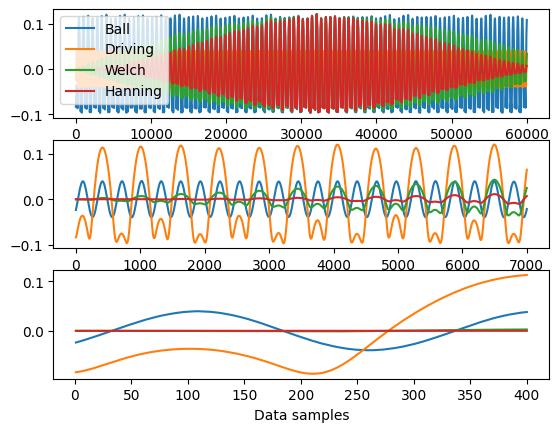

(array([ 31,  32, 183, 184, 335, 336]),)


In [4]:
# Apply window to bouncing ball signal
yh = y * hanning_window # ball Hanning
yw = y * welch_window   # ball Welch

# Plot the data, w/ & w/o windows
points = 60000
plt.subplot(311)
plt.plot(x[:points], y[:points], label='Ball')
plt.plot(x[:points], d[:points], label='Driving')
plt.plot(x[:points], yw[:points], label='Welch')
plt.plot(x[:points], yh[:points], label='Hanning')
plt.legend()

# Zoom in further
points = 7000
plt.subplot(312)
plt.plot(x[:points], d[:points], label='Driving')
plt.plot(x[:points], y[:points], label='Ball')
plt.plot(x[:points], yw[:points], label='Welch')
plt.plot(x[:points], yh[:points], label='Hanning')

# ENHANCE
points = 400
plt.subplot(313)
plt.plot(x[:points], d[:points], label='Driving')
plt.plot(x[:points], y[:points], label='Ball')
plt.plot(x[:points], yw[:points], label='Welch')
plt.plot(x[:points], yh[:points], label='Hanning')
plt.xlabel('Data samples')
plt.show()

# driving signal is 145Hz, completes a wave around 340 - 30 ~ 310 datapoints

zeros = np.where(abs(d[:points]) < 7e-4)
print(zeros)

Driving Signal was stated to bee 145 Hz. From the third subplot it can be approximated a complete wave of this signal occurs for $340 - 30 \approx 310$ datapoints. This is the period completed over this many data. Hence:

$$ 
Δ = (1/f_D) / points 
\\f_{samp} = 1/Δ \approx 44950 Hz
$$

Therefore, the sampling frequency is $f_{samp} \approx 4.4kHz$. This is crucial in finding the minimum frequency, $f_m$, which can fit an entire wavelength into data, and the Nyquist frequency, $f_M$, to finding the highest possible frequency in the dataset. Such values are:

$$ 
f_{m} = f_s / N, N = 2^{16}
\\ \approx 0.68Hz
\\f_{M} = f_s/2
\\ = 2.2kHz
$$

Text(0, 0.5, 'Power Spectral Density')

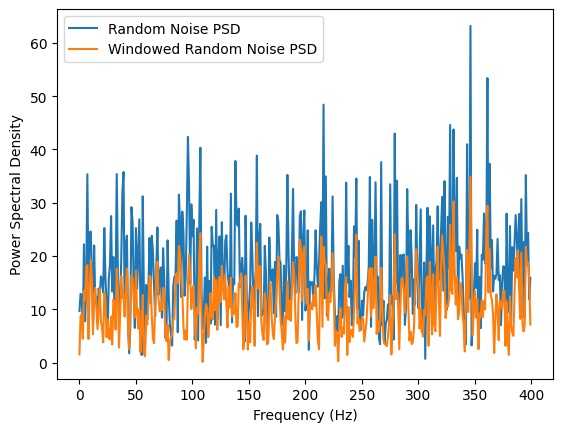

In [5]:
"""Introduce Noise"""
# Generate random noise
r = np.std(y) * np.random.randn(N)      # Random noise with same standard deviation as y
Pr = np.abs(fft(r))**2                  # Power spectral density of random noise

# Apply Hanning window to random noise
rw = r * hanning_window                  # Apply Hanning window to random noise
Prw = np.abs(fft(rw))**2                # Power spectral density of windowed random noise

# Plot the data (commented out as per your original code, if needed)
# plt.plot(x[:points], y[:points], label="Signal")
# plt.plot(x[:points], r[:points], label="Random Noise")
# plt.plot(x[:points], rw[:points], label="Windowed Random Noise")
# plt.legend()
# plt.show()

# Plot power spectral density (optional, as per MATLAB code)
plt.figure()
plt.plot(np.abs(fft(r))[:points], label="Random Noise PSD")
plt.plot(np.abs(fft(rw))[:points], label="Windowed Random Noise PSD")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")

Text(0, 0.5, '$|F|^2$')

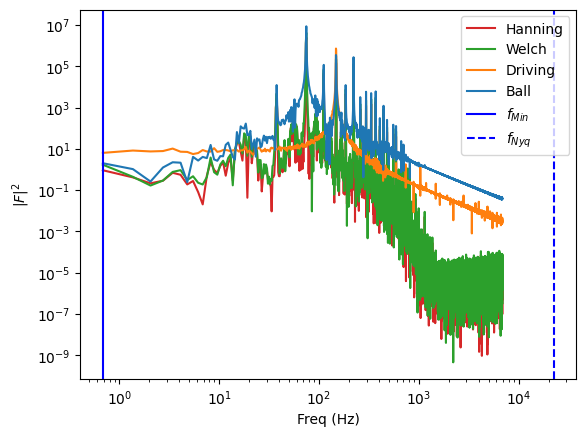

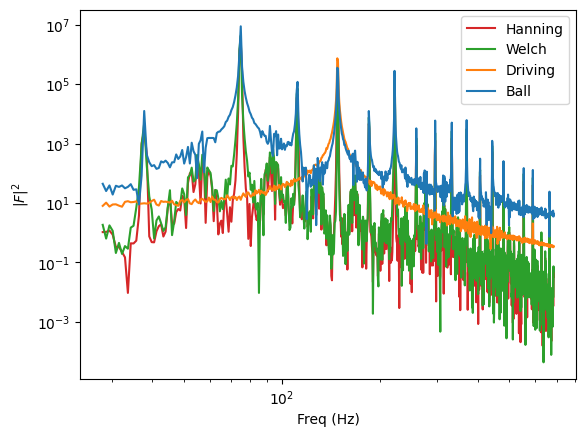

In [6]:
# Sampling frequency and Nyquist frequency
fSamp = 44950       # Sampling frequency, x2 max audible frequency
fNyq = fSamp / 2.0  # Nyquist frequency
fMin = fSamp / N    # Minimum frequency, 1 wavelength fits into datalength

# FFT and Power Spectral Density (PSD)
# P = np.abs(fft(np.sin(x/(200*np.pi))))**2 
Pd = np.abs(fft(d))**2      # of signal
Pb = np.abs(fft(y))**2      # pf ball height
Ph = np.abs(fft(yh))**2     # hanning
Pw = np.abs(fft(yw))**2     # welch
nfreq = np.arange(1, N + 1)
freq = nfreq * fSamp / N    # x-axis

# Plot the FFT results
l = 0
points = 10000
plt.figure()

plt.loglog(freq[l:points], Ph[l:points], label='Hanning', color = 'tab:red')
plt.loglog(freq[l:points], Pw[l:points], label='Welch', color = 'tab:green')
plt.loglog(freq[l:points], Pd[l:points], label='Driving', color = 'tab:orange')
plt.loglog(freq[l:points], Pb[l:points], label='Ball', color = 'tab:blue')
# plt.loglog(freq[l:points], P[l:points], label='$sin(x/200\pi)$', color = 'tab:purple')
plt.axvline(fMin, color='b', linestyle='-', label='$f_{Min}$')
plt.axvline(fNyq, color='b', linestyle='--', label='$f_{Nyq}$')
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('$|F|^2$')

# zoom in around area 145Hz, extend domain around it
# remove fm & fM as it disallows zooming
l = 40
points = 1000
plt.figure()

plt.loglog(freq[l:points], Ph[l:points], label='Hanning', color = 'tab:red')
plt.loglog(freq[l:points], Pw[l:points], label='Welch', color = 'tab:green')
plt.loglog(freq[l:points], Pd[l:points], label='Driving', color = 'tab:orange')
plt.loglog(freq[l:points], Pb[l:points], label='Ball', color = 'tab:blue')
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('$|F|^2$')


ValueError: x and y must have same first dimension, but have shapes (8191,) and (9999,)

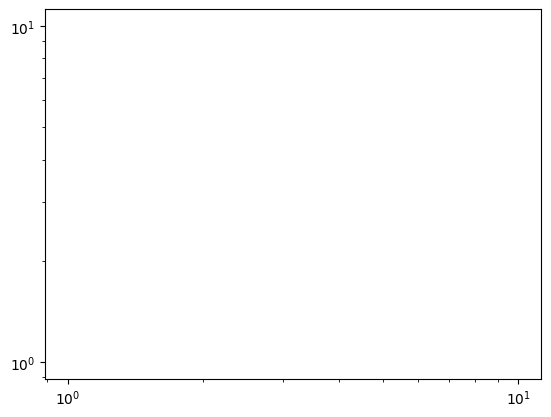

In [ ]:
# Averaging over Nav sections
Nav = 2**2                         # Number of sections to average over
ya = y.reshape(N // Nav, Nav)      # Reshape to get Nav sections
Na = N // Nav
n = np.arange(1, Na + 1)

# Hanning window for each section
hanning_section = 0.5 * (1 - np.cos(2 * np.pi * n / (Na - 1)))
welch_window = 1 - ((n-1/2*(N-1))/(1/2*(N-1)))

# Initialize PSD variables
Pba = np.zeros(Na)                      # Power Ball average
Pbaw = np.zeros(Na)                     # Power Ball average welch
Pbah = np.zeros(Na)                     # Power Ball average hanning


# # Averaging and windowing
for i in range(Nav):
    zh = ya[:, i] * hanning_section     # Apply hanning
    Pbah += np.abs(fft(zh))**2          # Power spectral density for averaged hanning data
    zw = ya[:, i] * hanning_section     # Apply welch
    Pbaw += np.abs(fft(zh))**2          # Power spectral density for averaged welch data
    za = ya[:, i]
    Pba += np.abs(fft(za))**2           # Power spectral density for averaged data


Pba /= Nav  # Normalize
Pbah /= Nav  # Normalize
Pbaw /= Nav  # Normalize

# set freq axis
afreq = np.arange(1, Na + 1) * fSamp / Na  # Frequencies for averaged data
fMin = fSamp / Na  # Recalculate minimum frequency

# Plot the averaged FFT results
l = 1
points = 10000
plt.figure()

plt.loglog(afreq[l:points], Pbah[l:points], label='Hanning', color = 'tab:red')
plt.loglog(afreq[l:points], Pbaw[l:points], label='Welch', color = 'tab:green')
plt.loglog(freq[l:points*Nav], Pd[l:points*Nav], label='Driving', color = 'tab:orange')
plt.loglog(freq[l:points*Nav], Pb[l:points*Nav], label='Ball', color = 'tab:blue')
plt.loglog(afreq[l:points], Pba[l:points], label='$\\bar{Ball}$', color = 'tab:cyan')


plt.axvline(fMin, color='b', linestyle='-', label='$f_{Min}$')
plt.axvline(fNyq, color='b', linestyle='--', label='$f_{Nyq}$')
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('$|F|^2$')

# zoom in around area 145Hz, extend domain around it
# remove fm & fM as it disallows zooming
l = 40
points = 1000
plt.figure()

plt.loglog(afreq[l:points], Pbah[l:points], label='Hanning', color = 'tab:red')
plt.loglog(afreq[l:points], Pbaw[l:points], label='Welch', color = 'tab:green')
plt.loglog(freq[l:points*Nav], Pd[l:points*Nav], label='Driving', color = 'tab:orange')
plt.loglog(freq[l:points*Nav], Pb[l:points*Nav], label='Ball', color = 'tab:blue')
plt.loglog(afreq[l:points], Pba[l:points], label='$\\bar{Ball}$', color = 'tab:cyan')

plt.axvline(fMin, color='b', linestyle='-', label='$f_{Min}$')
#plt.axvline(fNyq, color='b', linestyle='--', label='$f_{Nyq}$')
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('$|F|^2$')

Text(0, 0.5, '|F|^2')

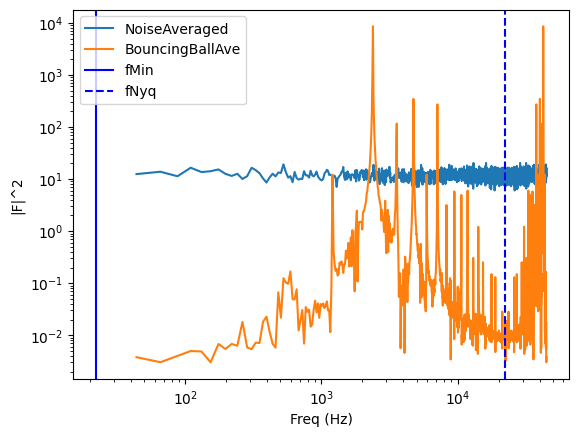

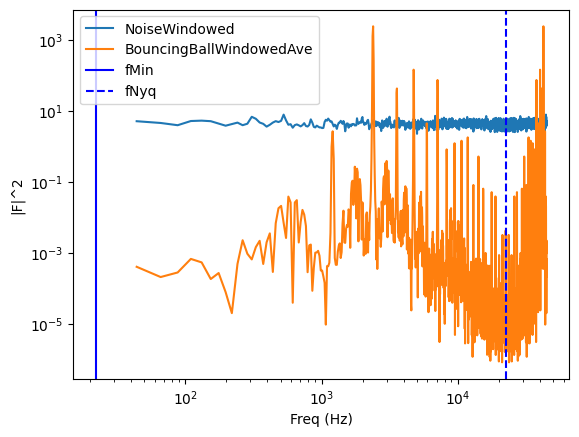

In [8]:
# Reshape data (bouncing ball signal and noise signal)
ya = y[:N].reshape(N // Nav, Nav)  # Bouncing ball signal reshaped into Nav sections
ra = r[:N].reshape(N // Nav, Nav)  # Noise signal reshaped into Nav sections

# Hanning window function for each section
n = np.arange(1, Na + 1)

# Initialize power spectral density (PSD) arrays
Pba = np.zeros(Na)  # Averaged PSD for bouncing ball
Pbaw = np.zeros(Na)  # Windowed and averaged PSD for bouncing ball
Pra = np.zeros(Na)  # Averaged PSD for noise
Praw = np.zeros(Na)  # Windowed and averaged PSD for noise

# Loop over the Nav sections
for i in range(Nav):
    # Apply Hanning window to each section of the bouncing ball signal
    zw = ya[:, i] * hanning_section
    Pbaw += np.abs(fft(zw))**2  # Windowed and averaged PSD for bouncing ball

    # Compute raw PSD for bouncing ball
    za = ya[:, i]
    Pba += np.abs(fft(za))**2  # Averaged PSD for bouncing ball

    # Apply Hanning window to each section of the noise signal
    rw = ra[:, i] * hanning_section
    Praw += np.abs(fft(rw))**2  # Windowed and averaged PSD for noise

    # Compute raw PSD for noise
    za = ra[:, i]
    Pra += np.abs(fft(za))**2  # Averaged PSD for noise

# Normalize the PSDs by dividing by Nav
Pba /= Nav
Pbaw /= Nav
Pra /= Nav
Praw /= Nav

# Create frequency axis for the FFT (in Hz)
nfreq = np.arange(1, Na + 1)
afreq = nfreq * fSamp / Na  # Frequencies for the averaged sections
fMin = fSamp / Na  # Minimum frequency (based on section length)

# Plotting the results
l = 1
points = 10000

# Plot for averaged PSD
plt.figure()
plt.loglog(afreq[l:points], Pra[l:points], label='NoiseAveraged')
plt.loglog(afreq[l:points], Pba[l:points], label='BouncingBallAve')
plt.axvline(fMin, color='b', linestyle='-', label='fMin')
plt.axvline(fNyq, color='b', linestyle='--', label='fNyq')
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('|F|^2')

# Plot for windowed and averaged PSD
plt.figure()
plt.loglog(afreq[l:points], Praw[l:points], label='NoiseWindowed')
plt.loglog(afreq[l:points], Pbaw[l:points], label='BouncingBallWindowedAve')
plt.axvline(fMin, color='b', linestyle='-', label='fMin')
plt.axvline(fNyq, color='b', linestyle='--', label='fNyq')
plt.legend()
plt.xlabel('Freq (Hz)')
plt.ylabel('|F|^2')